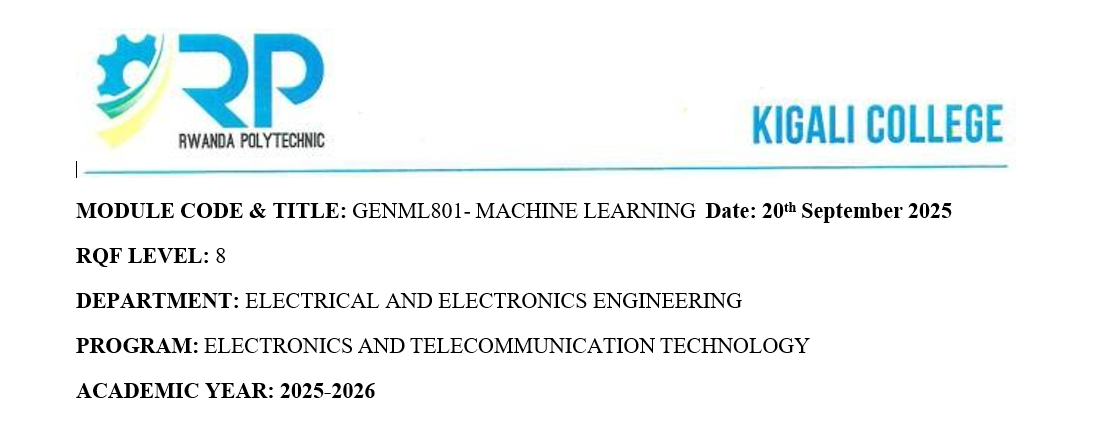

## names : NYAGATO Annet
## reg no: 25RP20520 

## 1.Import libraries
Loads all required Python libraries:

pandas & numpy → for data handling.

matplotlib & seaborn → for visualization.

scikit-learn → for train/test split, random forest model, and evaluation.

joblib → for saving the trained model.

In [30]:
# Predictive Maintenance for Base Stations - Notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

## 2.Load Dataset
Loads the dataset base_station_dataset.csv with a parsed timestamp column.

Prints dataset shape (rows × columns).


In [34]:
# 1. Load dataset
df = pd.read_csv('base_station_dataset.csv', parse_dates=['timestamp'])
print("Shape:", df.shape)
df.head()


Shape: (5000, 9)


,timestamp,site_id,traffic_load,ambient_temp,battery_voltage,psu_temp,fan_speed,power_consumption,failure
0,2024-01-01 00:00:00,1,44.36,29.06,46.80,46.49,3103.4,10.01,1
1,2024-01-01 01:00:00,4,43.13,34.24,47.73,49.35,2947.8,8.98,0
2,2024-01-01 02:00:00,4,61.53,33.67,47.61,43.24,3283.5,11.18,0
3,2024-01-01 03:00:00,3,62.29,28.04,46.11,43.53,3070.5,10.70,0
4,2024-01-01 04:00:00,3,41.97,16.32,46.71,39.57,2778.9,8.70,0


## Exploratory Data Analysis (EDA)
Descriptive statistics with df.describe().

Plots:

Failure class distribution (to check balance/imbalance of target variable).

Correlation heatmap of features (helps identify relationships).

                 timestamp     site_id  traffic_load  ambient_temp  \
count                 5000  5000.00000   5000.000000   5000.000000   
mean   2024-04-14 03:30:00     2.98560     50.218094     27.858598   
min    2024-01-01 00:00:00     1.00000      0.000000     10.350000   
25%    2024-02-22 01:45:00     2.00000     40.050000     24.570000   
50%    2024-04-14 03:30:00     3.00000     49.970000     27.810000   
75%    2024-06-05 05:15:00     4.00000     60.300000     31.192500   
max    2024-07-27 07:00:00     5.00000    101.810000     48.760000   
std                    NaN     1.41739     14.998419      5.017215   

       battery_voltage     psu_temp    fan_speed  power_consumption  \
count      5000.000000  5000.000000  5000.000000        5000.000000   
mean         47.520204    42.726990  3109.261700          10.016656   
min          43.690000    16.040000  2399.800000           4.350000   
25%          46.860000    37.857500  2972.525000           8.950000   
50%          4

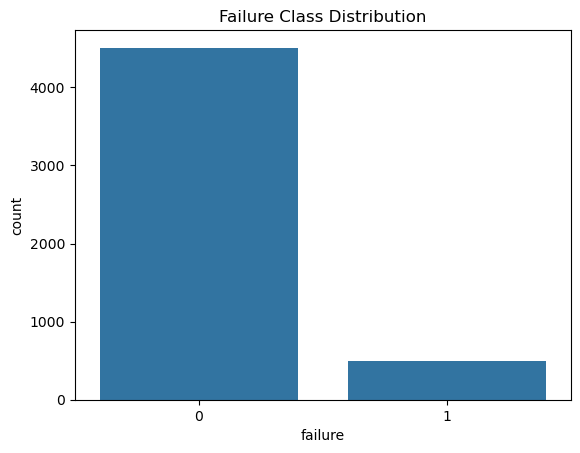

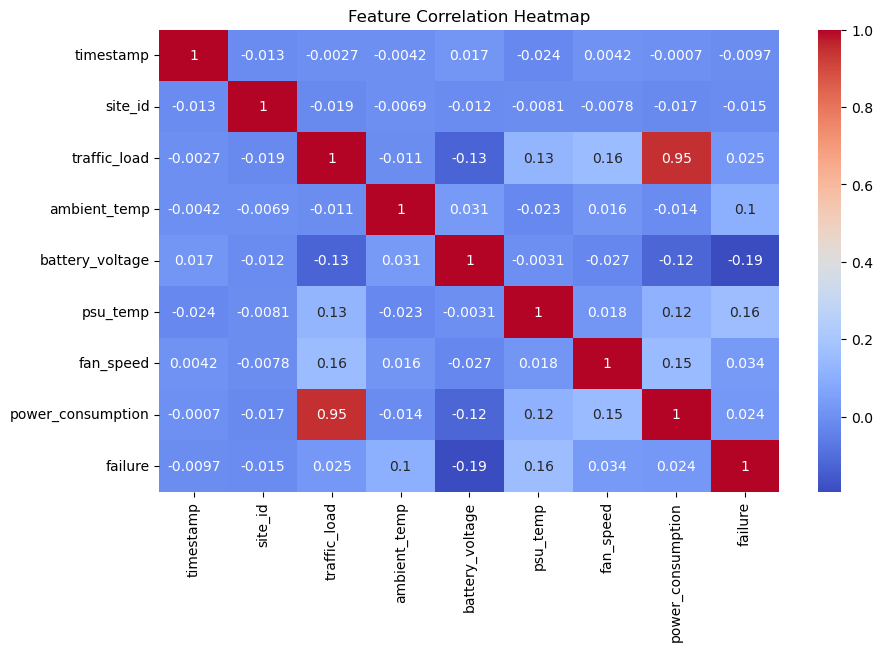

In [35]:
# 2. Exploratory Data Analysis (EDA)
print(df.describe())

# Plot failure distribution
sns.countplot(x='failure', data=df)
plt.title('Failure Class Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## Checked for Missing Values
I examined how many missing values each column in the dataset has using df.isnull().sum(). This helps identify data quality issues that need to be addressed later during feature engineering. Then, I visualized the missing values distribution using a heatmap. The heatmap highlights whether missing values are concentrated in specific columns/rows or spread across the dataset. This makes it easier to spot patterns.

Missing values per column:
timestamp            0
site_id              0
traffic_load         0
ambient_temp         0
battery_voltage      0
psu_temp             0
fan_speed            0
power_consumption    0
failure              0
dtype: int64


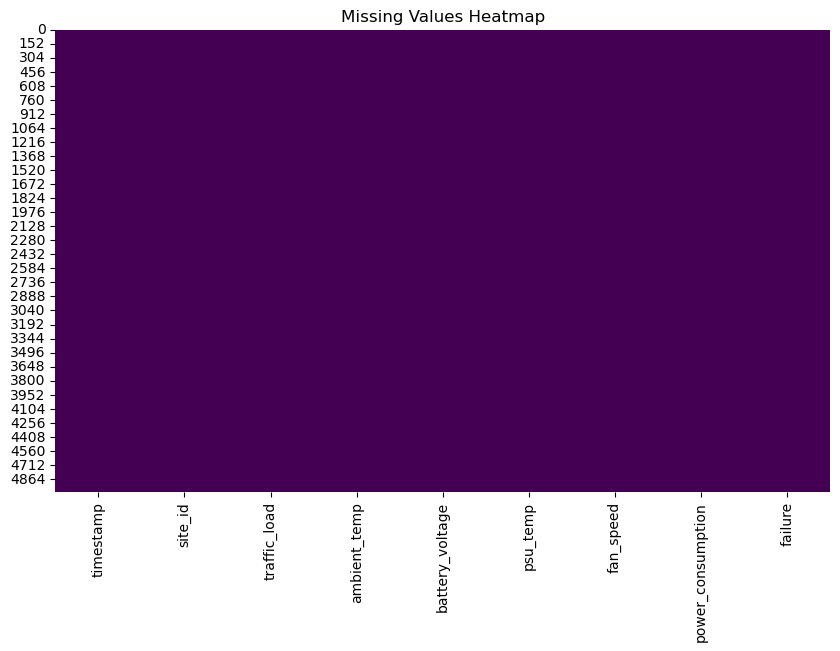

In [18]:
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

# Visualize missing values heatmap with seaborn (instead of missingno)
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()



## Performed Univariate Analysis (Histograms & Boxplots)
I plotted histograms for each numerical feature to see how the values are distributed (normal, skewed, uniform, etc.). This gives insights into the shape of the data.
Then, I used boxplots to detect outliers for each numeric column. Outliers appear as points outside the whiskers of the boxplot, which helps me identify potential anomalies.

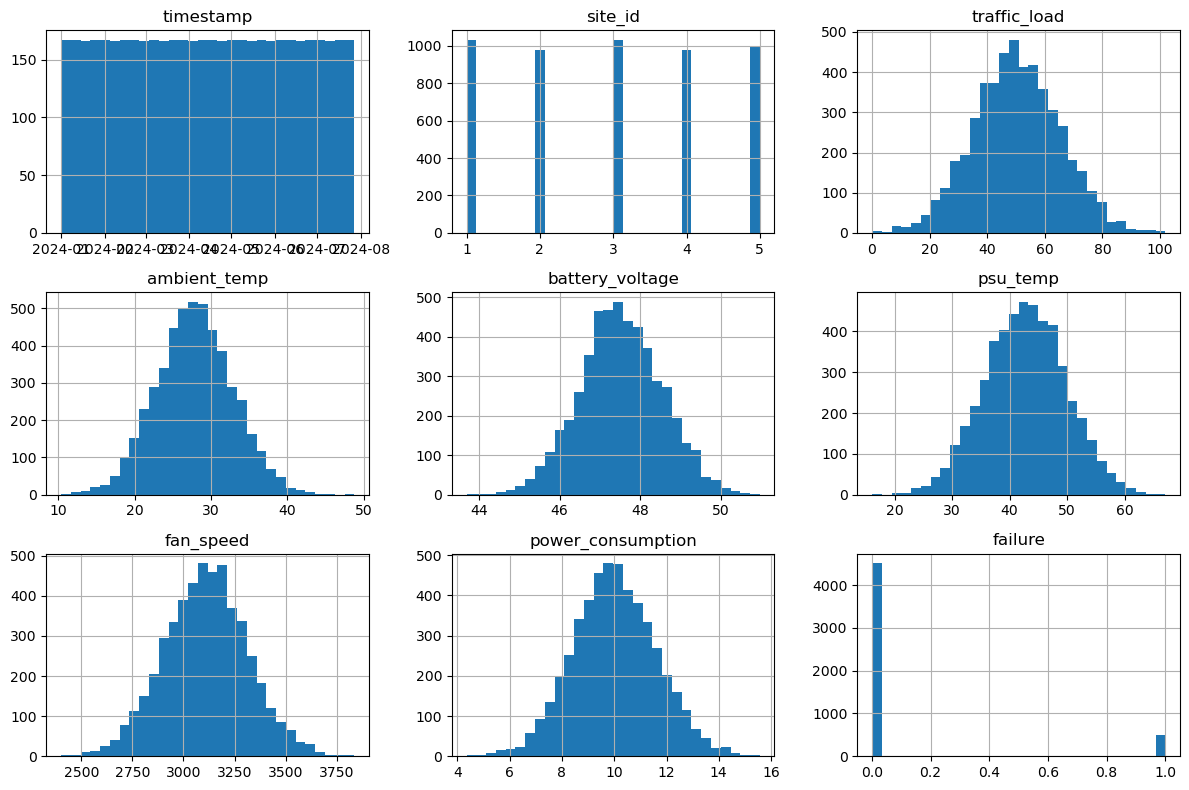

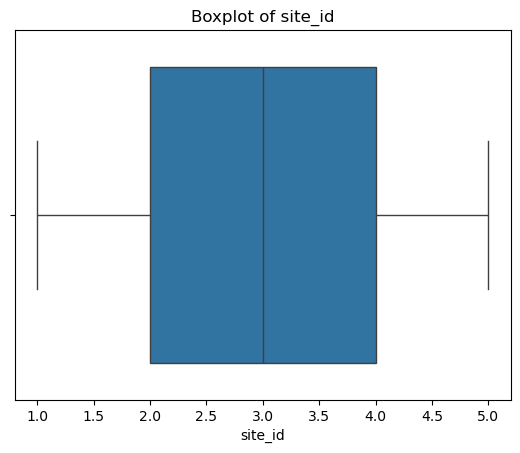

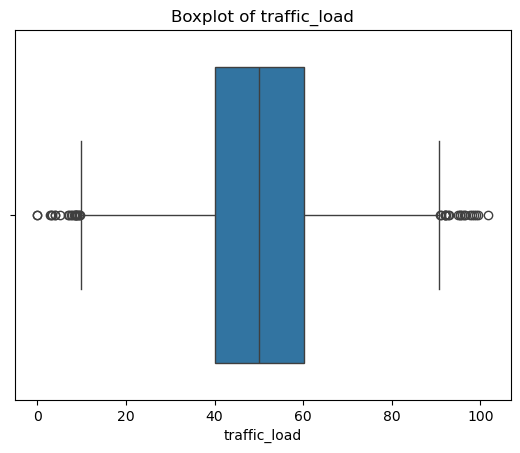

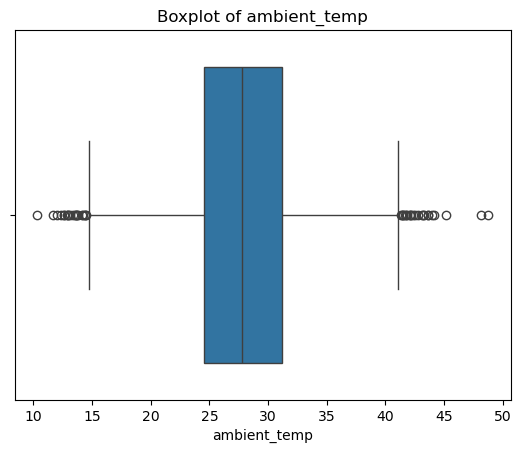

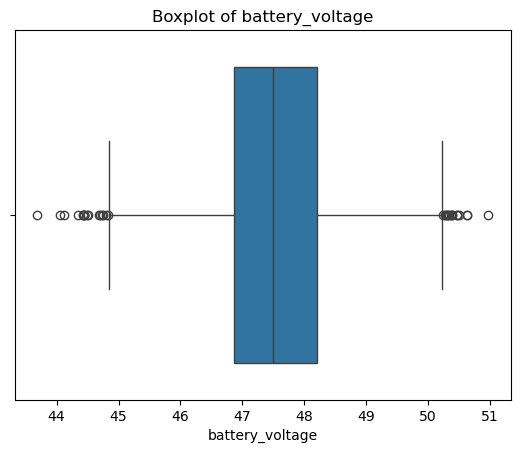

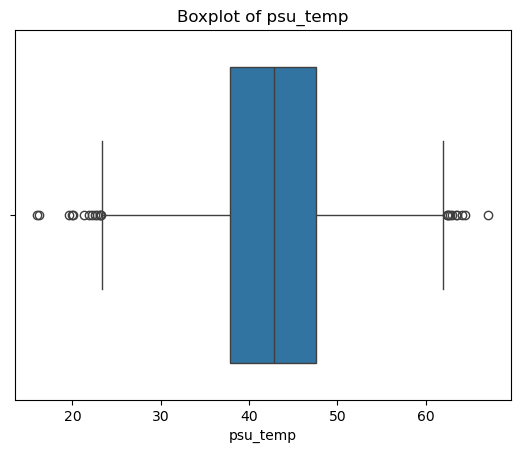

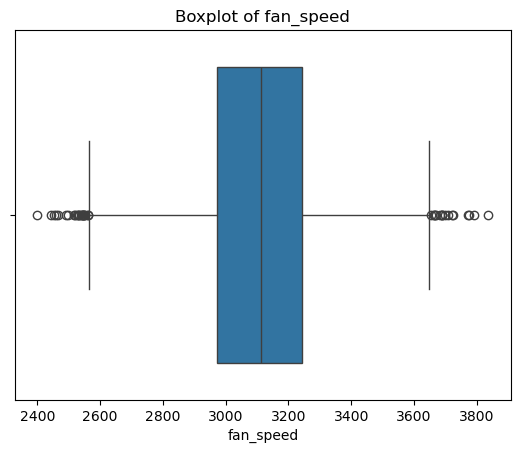

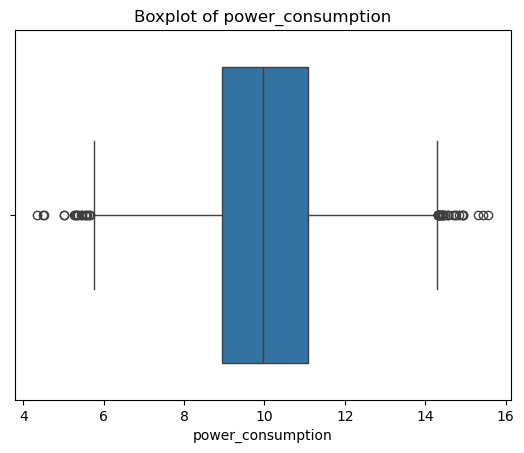

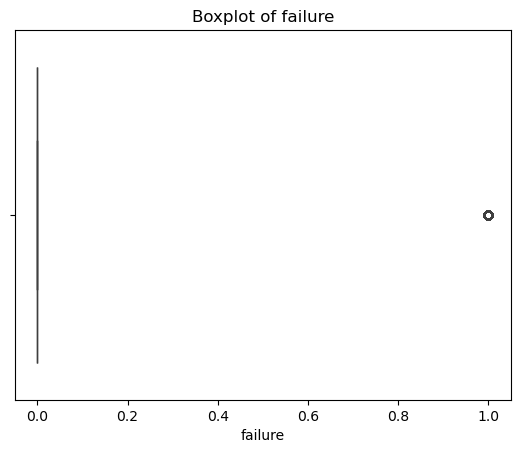

In [19]:
# Univariate Analysis: Histograms for numerical features
df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

# Boxplots to detect outliers
for col in df.select_dtypes(include=np.number).columns:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


## Conducted Bivariate Analysis (Scatter Plots vs Target)
I explored how each numerical feature relates to the target variable (failure) using scatter plots. This helps to see if there’s a pattern — for example, whether higher or lower sensor readings correlate with equipment failures.

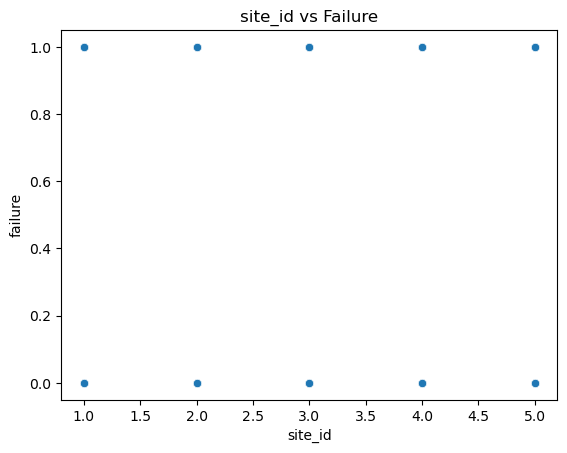

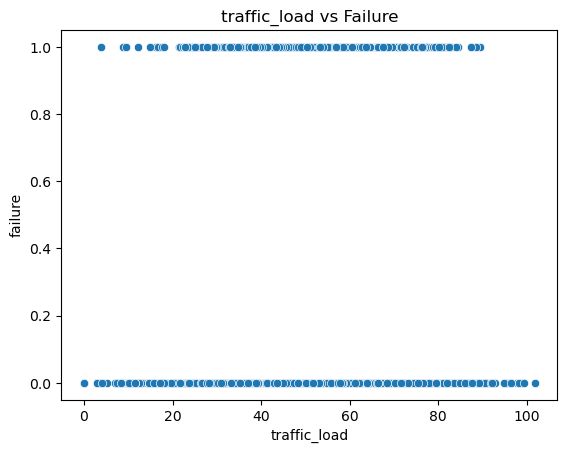

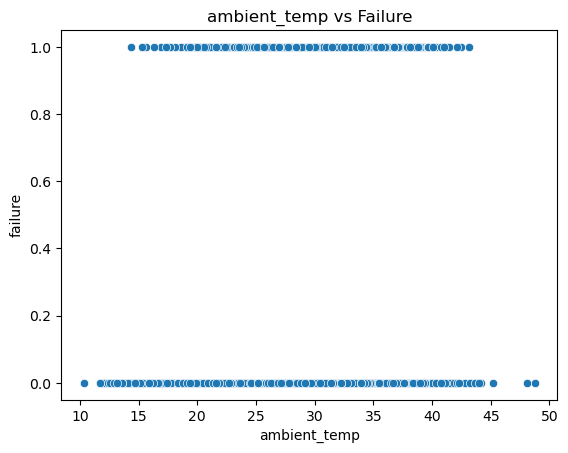

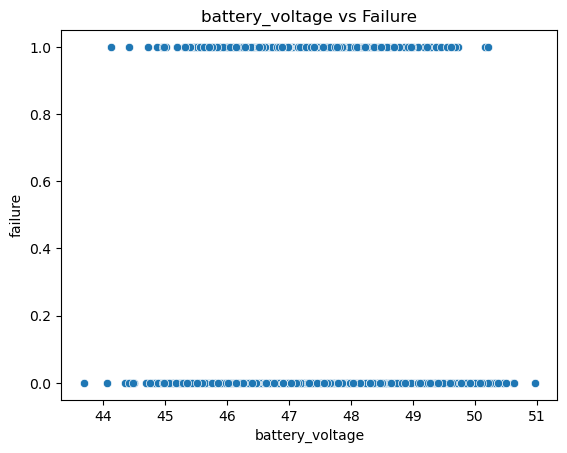

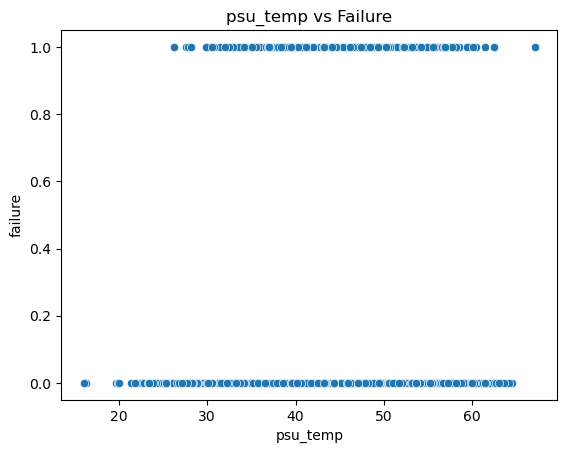

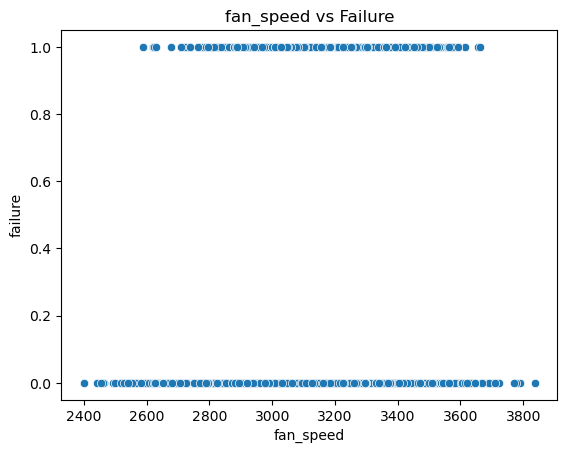

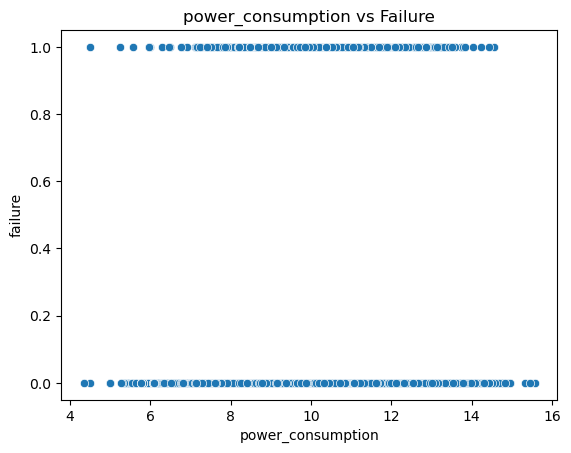

In [20]:
# Bivariate Analysis: Scatter plots of numerical features vs target
for col in df.select_dtypes(include=np.number).columns:
    if col != 'failure':
        plt.figure()
        sns.scatterplot(x=df[col], y=df['failure'])
        plt.title(f'{col} vs Failure')
        plt.show()

## Did Multivariate Analysis (Pair Plots)
Finally, I used a pair plot on a sample of the dataset. This visualizes the relationships between multiple features at once, colored by the target variable. It allows spotting clusters, trends, or separability between failure and non-failure cases across feature combinations.

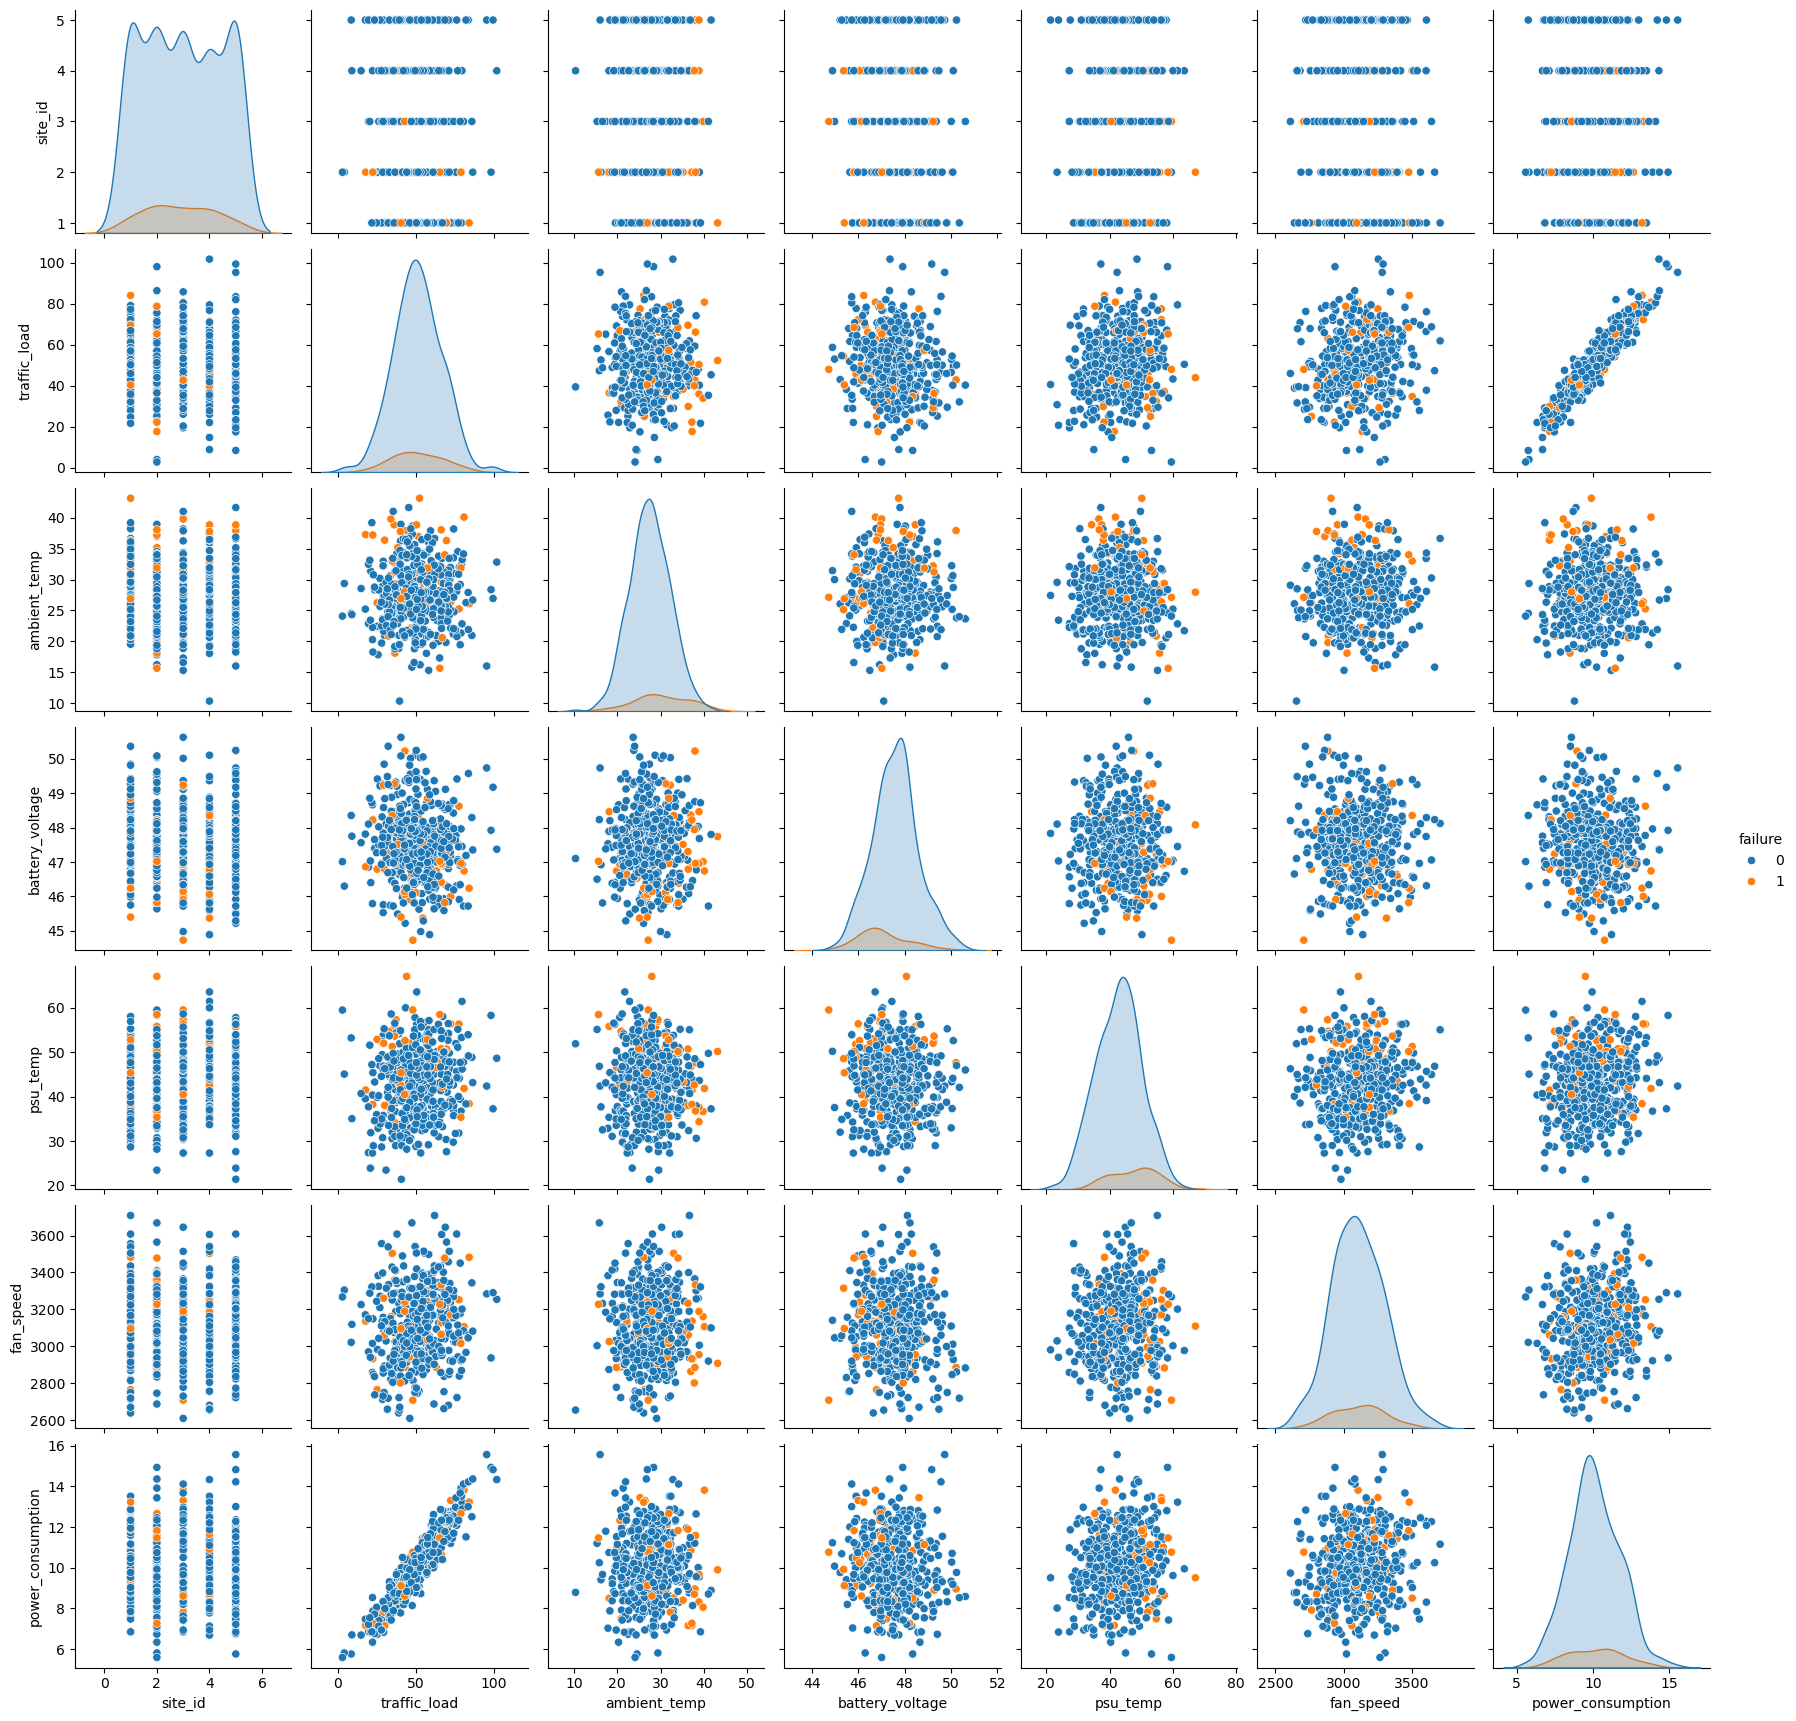

In [21]:
# Multivariate Analysis: Pairplot (sampled for performance)
sns.pairplot(df.sample(min(500, len(df))), hue='failure')
plt.show()


## Feature Engineering
Drops timestamp (not directly useful for training).

Defines features (X) and target (y = failure).


In [22]:
# 3. Feature Engineering
# Drop timestamp for modeling (can extract features later if needed)
X = df.drop(columns=['failure','timestamp'])
y = df['failure']
# Feature extraction from timestamp (if you keep it)
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month


## Handle missing values and outliers
-Impute with median for numeric columns

-Cap values using IQR method

In [23]:
# Handle missing values: Impute with median for numeric columns
for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

# Handle outliers: Cap values using IQR method
for col in X.select_dtypes(include=np.number).columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X[col] = np.where(X[col] < lower_bound, lower_bound, X[col])
    X[col] = np.where(X[col] > upper_bound, upper_bound, X[col])


## identify categorical and numerical features 

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Define transformers
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


## split dataset
Splits dataset into 80% train / 20% test, while keeping failure ratio balanced (stratify=y).

In [25]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

## Model Training
Trains a Random Forest Classifier with:

-200 trees (n_estimators=200).

-class_weight='balanced' to handle imbalanced dataset.

-Fits model on training set.

In [26]:
# 4. Model Training
clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

## Evaluation
Evaluates model performance:

-Predictions (y_pred) and probabilities (y_proba).

-Classification report → Precision, Recall, F1-score.

-ROC AUC score → measures separability of classes.

-Confusion matrix heatmap → visualizes correct vs wrong predictions.

              precision    recall  f1-score   support

           0       0.90      0.99      0.95       902
           1       0.17      0.01      0.02        98

    accuracy                           0.90      1000
   macro avg       0.53      0.50      0.48      1000
weighted avg       0.83      0.90      0.86      1000

ROC AUC: 0.8346474953617811


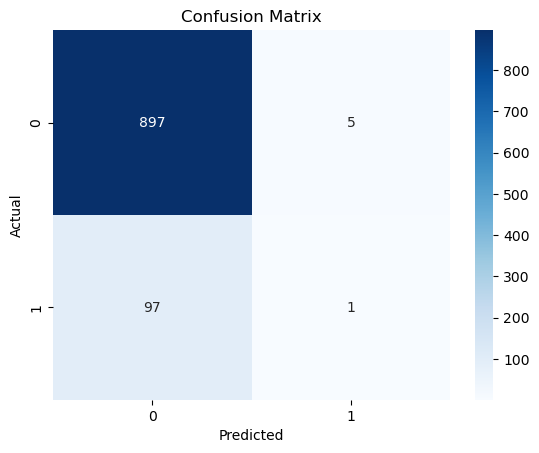

In [27]:
# 5. Evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Saving the Model

Finally, after training and evaluating the Random Forest model, I saved it so it could be reused later without retraining. I used joblib to export the model into a file named rf_model.joblib. This step is useful for deployment, where the trained model can be loaded and used for real-time predictive maintenance tasks without going through the full training pipeline again.

In [28]:

joblib.dump(clf, 'rf_model.joblib')
print("Model saved as rf_model.joblib")

Model saved as rf_model.joblib


## deploying model 
the final step is to deploy model using streamlit.so i  create an python file on other side which contain scripts used to deploy model